In [34]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np
import random
import re

In [14]:
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224), scale = (0.5, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

In [9]:
batchsize = 10
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

In [15]:
class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample

In [21]:
trainset = CovidCTDataset(root_dir='Image-processed',
                          txt_COVID='Data-split/COVID/trainCT_COVID.txt',
                          txt_NonCOVID='Data-split/NonCOVID/trainCT_NonCOVID.txt',
                          transform= train_transformer)
valset = CovidCTDataset(root_dir='Image-processed',
                          txt_COVID='Data-split/COVID/valCT_COVID.txt',
                          txt_NonCOVID='Data-split/NonCOVID/valCT_NonCOVID.txt',
                          transform= val_transformer)
testset = CovidCTDataset(root_dir='Image-processed',
                          txt_COVID='Data-split/COVID/testCT_COVID.txt',
                          txt_NonCOVID='Data-split/NonCOVID/testCT_NonCOVID.txt',
                          transform= val_transformer)
print(trainset.__len__())
print(valset.__len__())
print(testset.__len__())


train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)

425
118
203


In [32]:
print(trainset.__getitem__(0)['img'].size())

torch.Size([3, 224, 224])


1


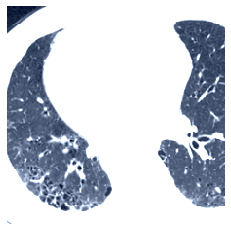

In [42]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h


x = trainset.__getitem__(400)['img']
label = trainset.__getitem__(400)['label']
myimshow(x)
print(label)